#   Does Speed Kill…Base Hits?
## Exploring acceleration as a proxy for defensive ability

by Ethan Rendon

# Import modules used in program

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import math

Mounted at /content/drive


# Load data (if running on local server replace file names)

In [2]:
ball_pos=pd.read_csv('/content/drive/MyDrive/smt comp/ball_pos.csv',on_bad_lines='skip')
ball_pos = ball_pos.rename(columns = {'ball_position_x':'field_x','ball_position_y':'field_y','ball_position_z':'field_z'})
print('Size of ball_pos',len(ball_pos))
game_events=pd.read_csv('/content/drive/MyDrive/smt comp/game_events.csv',on_bad_lines='skip')
print('Size of game_events',len(game_events))
game_info=pd.read_csv('/content/drive/MyDrive/smt comp/game_info.csv',on_bad_lines='skip')
print('Size of game_info',len(game_info))
player_pos=pd.read_csv('/content/drive/MyDrive/smt comp/player_pos.csv',on_bad_lines='skip')
print('Size of player_pos',len(player_pos))
team_info=pd.read_csv('/content/drive/MyDrive/smt comp/team_info.csv',on_bad_lines='skip')
print('Size of team_info',len(team_info))
full_pos = pd.concat([player_pos,ball_pos])
full_pos['new_id'] = full_pos['game_str'] + full_pos['play_id'].astype(str)
print('Size of full_pos',len(full_pos))
full_pos["player_position"].fillna(0, inplace = True)

Size of ball_pos 785041
Size of game_events 103444
Size of game_info 26315
Size of player_pos 20305730
Size of team_info 1039
Size of full_pos 21090771


# Run on one player (CF with most plays)

In [65]:
playcount = game_info.groupby('center_field').size().to_csv('playcount.csv')
playcount=pd.read_csv('/content/playcount.csv',on_bad_lines='skip')
playcount = playcount.rename(columns={"0": "count"})
player1 = playcount.iloc[1]['center_field']
player1_game = game_info.query(f'center_field == {player1}')
gameunique = player1_game['game_str'].unique()
guli = list(gameunique)
len(gameunique)

13

In [66]:
game = game_events
game = game.query(f'game_str == @guli')
pos = full_pos
pos = pos.query(f'game_str==@guli')

In [68]:
player1_plays = pd.DataFrame({'game_str':[],
        'play_id':[],
        'play_per_game':[],
        'line_distance':[],
        'full_distance':[],
        'route_efficiency':[],
        'time_delta':[],
        'avg_speed':[],
        'first_step_speed':[],
        'first_step_check':[],
        'hang_time':[],
        'catch_difficulty':[],
        'easy_catch':[]
       } )

for i in range(len(guli)):

  loophold = game.query(f'game_str == "{guli[i]}"').sort_values(by='play_per_game').reset_index().drop(columns=['index','at_bat'])

  for index, row in loophold.iterrows(): 
      # If ball bounce > 150 from player at start of play remove 
      # If bounce or not store in column 

    if loophold.iat[index,4] == 10 and loophold.iat[index,5] == 4 and loophold.iat[index+1,4] == 8 and loophold.iat[index+1,5] == 2: 

      # Fielder position at time of contact
      contactCF_pos = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 8 and timestamp == {loophold.iat[index,3]}') 
      fielder_x_contact = contactCF_pos['field_x'].values
      fielder_y_contact = contactCF_pos['field_y'].values
        
      # Ball position at time of catch
      catch_pos = pos.query(f'play_id == {loophold.iat[index+1,1]} and game_str == "{loophold.iat[index+1,0]}" and player_position == 0 and timestamp == {loophold.iat[index+1,3]}') 
      ball_x_catch = catch_pos['field_x'].values
      ball_y_catch = catch_pos['field_y'].values

      # Ball position at time of contact
      contact_pos1 = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 0')
      contact_pos = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 0 and timestamp == {loophold.iat[index,3]}') 
      ball_x_contact= contact_pos['field_x'].values
      ball_y_contact = contact_pos['field_y'].values

      if len(contact_pos1) > 50: # limit properly tagged data ~ 50 frames the data is actually a ball hit to CF and caught

        # Calculate distance between fielder position at contact and ball position at point of catch (range is max)
        x0,x1,y0,y1 = fielder_x_contact,ball_x_catch,fielder_y_contact,ball_y_catch
        line_distance = math.sqrt( ((x0-x1)**2)+((y0-y1)**2) )

        # Calculate full distance fielder traveled over play
        posfilter = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 8').sort_values(by='timestamp',ascending=True) # filter position data
        posfilter['timestamp'] = posfilter['timestamp'] / 1000 # convert to seconds
        posfilter['dist'] = 0 # intialize new column for distance

        for j in range(len(posfilter)):
          try:
            x0,y0,x1,y1 = posfilter.iat[j,4], posfilter.iat[j,5], posfilter.iat[j+1,4], posfilter.iat[j+1,5] # apply distance formula to current row and current row + 1 points
            posfilter.iat[j,8] = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

          except IndexError: # stop from crashing at max because there is no i+1 row after the last row
            pass

        full_distance = posfilter['dist'].sum()

        # Route efficiency formula is line / full distance
        route_efficiency = line_distance / full_distance

        # Delta in time of play
        time_delta = (posfilter['timestamp'].max() - posfilter['timestamp'].min())

        # AVG Speed (ft/s) 
        avg_speed = full_distance / time_delta

        # VECTOR
        first_step_check = 0
        vector = posfilter.query('dist > 0.1').sort_values(by='timestamp',ascending=True).head(20).sort_values(by='timestamp',ascending=True) # @ 0.1 cutoff for speed increase, 20 is 1 of data
        if len(vector) > 0:
          
          #Speed of first step
          x0,y0,x1,y1 = vector.iat[0,4],vector.iat[0,5],vector.iat[19,4],vector.iat[19,5]
          first_step_speed = math.sqrt( ((x0-x1)**2)+((y0-y1)**2)) 

          vector_last = vector.tail(1)
          x0,y0,x1,y1 = vector_last['field_x'],vector_last['field_y'],ball_x_catch,ball_y_catch
          vector_check = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

          # if fielder is making efficient first step output 1 meaning that fielder is getting closer to ball position  
          if vector_check < line_distance:  
            first_step_check = 1
        else:
          first_step_speed = 'NaN'

        # HANG TIME
        hang_time = len(contact_pos1)/20 # every 20 rows is 1 second

        # CATCH DIFF
        point = (line_distance,hang_time)
        constant = (0.0333333*point[0])+1.83333 # above are catches made >50% of the time below is less
        if point[1] > constant: 
          easy_catch = 1 # if ball is > 50% == easy 
        else:
          easy_catch = 0
        catch_difficulty = 100 - (100 * point[1]/constant)
        if catch_difficulty < 0: # catch (hahahaha) all the catches are easier than 0 to floor then
          catch_difficulty = 0 

      
        # Update DataFrame with real values!
        if route_efficiency < 1 and avg_speed < 32 : # to remove mislabeled data as there is a pitch solely between pitcher and catcher that is tagged as CF catching ball
          player1_plays.loc[len(player1_plays.index)] = [
              loophold.iat[index,0], # game_str
              loophold.iat[index,1], # play_id
              loophold.iat[index,2], # play_per_game
              line_distance,
              full_distance,
              route_efficiency,
              time_delta, 
              avg_speed,
              first_step_speed,
              first_step_check,
              hang_time,
              catch_difficulty,
              easy_catch
              ]

# RANGE is max line_distance == caught
range = player1_plays['line_distance'].max()
print("RANGE:",range)

# AVG Speed is AVG of all AVGs
speedavg = player1_plays['avg_speed'].mean()
print("Avg Speed:",speedavg)

# Peak Speed is MAX of all AVGs
speedmax = player1_plays['avg_speed'].max()
print("Max Speed:",speedmax)

# AVG first step speed
first_step_speedavg = player1_plays['first_step_speed'].mean()
print("Avg Speed on 1st Step:",first_step_speedavg)

# AVG catch difficulty
avgcatchdiff = player1_plays['catch_difficulty'].mean()
print("Avg Catch Diff:",avgcatchdiff)

# Good first step%
firststeprate = 100 * (player1_plays['first_step_check'].sum() / len(player1_plays))
print("Good First Step%:",firststeprate)

# Easy_catch% -> can also do easy catch% made
easycatchrate = 100 * (player1_plays['easy_catch'].sum() / len(player1_plays))
print("Easy Catch%:",easycatchrate)
player1_plays.to_csv('mostplaysCF.csv')

RANGE: 95.21162336075832
Avg Speed: 8.649650701412199
Max Speed: 18.536004103546126
Avg Speed on 1st Step: 5.836101911634016
Avg Catch Diff: 0.0
Good First Step%: 76.19047619047619
Easy Catch%: 100.0


# Run on All CF

In [3]:
#make df 

career_stats = pd.DataFrame(columns=['center_field','avg_range','range','route_efficiency','speed','max_speed','first_step_speed','max_first_step_speed','first_step_rate','easy_catch_rate'])
player1_plays = pd.DataFrame(columns=['center_field','game_str','play_id','play_per_game','line_distance','full_distance','route_efficiency','time_delta','avg_speed','first_step_speed','first_step_check','hang_time','easy_catch'])

# get data from CF only
playcount = game_info.groupby('center_field').size().to_csv('playcount.csv')
playcount=pd.read_csv('/content/playcount.csv',on_bad_lines='skip')
playcount = playcount.rename(columns={"0": "count"})

In [4]:
for iter1 in range(len(playcount.index)): # note range is used elsewhere so beware when running for loops with this feature
  try:
    print('start',iter1)
    player1 = playcount.iloc[iter1]['center_field']
    player1_game = game_info.query(f'center_field == {player1}')
    gameunique = player1_game['game_str'].unique()
    guli = list(gameunique)

    game = game_events
    game = game.query(f'game_str == @guli')
    pos = full_pos.query(f'game_str==@guli')

    for iter2 in range(len(guli)):
      loophold = game.query(f'game_str == "{guli[iter2]}"').sort_values(by='play_per_game').reset_index().drop(columns=['index','at_bat'])   
      
      for index,row in loophold.iterrows():

        if loophold.iat[index,4] == 10 and loophold.iat[index,5] == 4 and loophold.iat[index+1,4] == 8 and loophold.iat[index+1,5] == 2: 

          # Fielder position at time of contact
          contactCF_pos = pos.query(f'play_id == {int(loophold.iat[index,1])} and game_str == "{loophold.iat[index,0]}" and player_position == 8 and timestamp == {int(loophold.iat[index,3])}') 
          fielder_x_contact = contactCF_pos['field_x'].values
          fielder_y_contact = contactCF_pos['field_y'].values
            
          # Ball position at time of catch
          try:
            catch_pos = pos.query(f'play_id == {int(loophold.iat[index+1,1])} and game_str == "{loophold.iat[index+1,0]}" and player_position == 0 and timestamp == {int(loophold.iat[index+1,3])}') 
            ball_x_catch = catch_pos['field_x'].values
            ball_y_catch = catch_pos['field_y'].values

            # Ball position at time of contact
            contact_pos1 = pos.query(f'play_id == {int(loophold.iat[index,1])} and game_str == "{loophold.iat[index,0]}" and player_position == 0')
            contact_pos = pos.query(f'play_id == {int(loophold.iat[index,1])} and game_str == "{loophold.iat[index,0]}" and player_position == 0 and timestamp == {int(loophold.iat[index,3])}') 
            ball_x_contact= contact_pos['field_x'].values
            ball_y_contact = contact_pos['field_y'].values

            if len(contact_pos1) > 50: # limit properly tagged data ~ 50 frames the data is actually a ball hit to CF and caught

              # Calculate distance between fielder position at contact and ball position at point of catch (range is max)
              x0,x1,y0,y1 = fielder_x_contact,ball_x_catch,fielder_y_contact,ball_y_catch
              line_distance = math.sqrt( ((x0-x1)**2)+((y0-y1)**2) )

              # Calculate full distance fielder traveled over play
              posfilter = pos.query(f'play_id == {int(loophold.iat[index,1])} and game_str == "{loophold.iat[index,0]}" and player_position == 8').sort_values(by='timestamp',ascending=True) # filter position data
              posfilter['timestamp'] = posfilter['timestamp'] / 1000 # convert to seconds
              posfilter['dist'] = 0 # intialize new column for distance

              for j in range(len(posfilter)):
                try:
                  x0,y0,x1,y1 = posfilter.iat[j,4], posfilter.iat[j,5], posfilter.iat[j+1,4], posfilter.iat[j+1,5] # apply distance formula to current row and current row + 1 points
                  posfilter.iat[j,8] = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

                except IndexError: # stop from crashing at max because there is no i+1 row after the last row
                  pass

              full_distance = posfilter['dist'].sum()

              # Route efficiency formula is line / full distance
              route_efficiency = line_distance / full_distance

              # Delta in time of play
              time_delta = (posfilter['timestamp'].max() - posfilter['timestamp'].min())

              # AVG Speed (ft/s) 
              avg_speed = full_distance / time_delta

              # VECTOR
              first_step_check = 0
              vector = posfilter.query('dist > 0.1').sort_values(by='timestamp',ascending=True).head(20).sort_values(by='timestamp',ascending=True) # @ 0.1 cutoff for speed increase, 20 is 1 of data
              if len(vector) > 0:
                
                #Speed of first step
                x0,y0,x1,y1 = vector.iat[0,4],vector.iat[0,5],vector.iat[19,4],vector.iat[19,5]
                first_step_speed = math.sqrt( ((x0-x1)**2)+((y0-y1)**2)) 

                vector_last = vector.tail(1)
                x0,y0,x1,y1 = vector_last['field_x'],vector_last['field_y'],ball_x_catch,ball_y_catch
                vector_check = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

                # if fielder is making efficient first step output 1 meaning that fielder is getting closer to ball position  
                if vector_check < line_distance:  
                  first_step_check = 1
              else:
                first_step_speed = 'NaN'

              # HANG TIME
              hang_time = len(contact_pos1)/20 # every 20 rows is 1 second

              # CATCH DIFF
              point = (line_distance,hang_time)
              constant = (0.0333333*point[0])+1.83333 # above are catches made >50% of the time below is less
              if point[1] > constant: 
                easy_catch = 1 # if ball is > 50% == easy 
              else:
                easy_catch = 0

              # Update DataFrame with real values!
              if route_efficiency < 1 and avg_speed < 32 : # to remove mislabeled data as there is a pitch solely between pitcher and catcher that is tagged as CF catching ball
                
                player1_plays_entry = {'center_field':player1,
                        'game_str':loophold.iat[index,0],
                        'play_id':loophold.iat[index,1],
                        'play_per_game':loophold.iat[index,2],
                        'line_distance':line_distance,
                        'full_distance':full_distance,
                        'route_efficiency':route_efficiency,
                        'time_delta':time_delta,
                        'avg_speed':avg_speed,
                        'first_step_speed':first_step_speed,
                        'first_step_check':first_step_check,
                        'hang_time':hang_time,
                        'easy_catch':easy_catch
                }
                player1_plays.loc[len(player1_plays)] = player1_plays_entry

          except TypeError:
            print('error')

    this = player1_plays.query(f'center_field == {player1}')
    
    career_stats_entry = {'center_field':player1,
                          'avg_range':this['line_distance'].mean(),
                          'range':this['line_distance'].max(),
                          'route_efficiency':this['route_efficiency'].mean(),
                          'speed':this['avg_speed'].mean(),
                          'max_speed':this['avg_speed'].max(),
                          'first_step_speed':this['first_step_speed'].mean(),
                          'max_first_step_speed':this['first_step_speed'].max(),
                          'first_step_rate':100 * (this['first_step_check'].sum() / len(this)),
                          'easy_catch_rate':100 * (this['easy_catch'].sum() / len(this))
    }

    career_stats.loc[len(career_stats)] = career_stats_entry
    print('end',iter1)
  except ZeroDivisionError:
    print('zero error')
career = career_stats.to_csv('career.csv')
topCF_plays = player1_plays.to_csv('cf_plays.csv')
display(player1_plays)

start 0
end 0
start 1
end 1
start 2
end 2
start 3
end 3
start 4
end 4
start 5
end 5
start 6
error
end 6
start 7
zero error
start 8
end 8
start 9
end 9
start 10
end 10
start 11
end 11
start 12
end 12
start 13
end 13
start 14
end 14
start 15
end 15
start 16
end 16
start 17
end 17
start 18
end 18
start 19
end 19
start 20
end 20
start 21
end 21
start 22
end 22
start 23
end 23
start 24
end 24
start 25
end 25
start 26
end 26
start 27
end 27
start 28
end 28
start 29
end 29
start 30
end 30
start 31
end 31
start 32
end 32
start 33
end 33
start 34
end 34
start 35
end 35
start 36
end 36
start 37
end 37
start 38
end 38
start 39
end 39
start 40
end 40
start 41
end 41
start 42
end 42
start 43
end 43
start 44
end 44
start 45
end 45
start 46
end 46
start 47
end 47
start 48
end 48
start 49
end 49
start 50
end 50
start 51
end 51
start 52
error
end 52
start 53
end 53
start 54
end 54
start 55
end 55
start 56
end 56
start 57
end 57
start 58
end 58
start 59
end 59
start 60
end 60
start 61
end 61
start 62
en

,center_field,game_str,play_id,play_per_game,line_distance,full_distance,route_efficiency,time_delta,avg_speed,first_step_speed,first_step_check,hang_time,easy_catch
0,1144,1903_19_TeamNL_TeamB,21,22,60.824734,73.067377,0.832447,7.600,9.614129,3.257671,1,4.30,1
1,1144,1903_19_TeamNL_TeamB,64,66,15.220873,28.867191,0.527272,7.500,3.848959,5.154491,0,4.20,1
2,1144,1903_19_TeamNL_TeamB,119,123,67.851808,85.574268,0.792900,13.350,6.410057,6.198561,1,8.40,1
3,1144,1903_19_TeamNL_TeamB,164,168,32.386829,53.805335,0.601926,11.900,4.521457,3.925780,1,6.75,1
4,1144,1903_19_TeamNL_TeamB,223,227,24.639261,34.055394,0.723505,8.200,4.153097,3.123744,1,4.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,9871,1901_01_TeamLG_TeamA3,207,207,34.595452,47.457366,0.728980,3.700,12.826315,1.994145,0,3.30,1
583,9871,1901_01_TeamLG_TeamA3,250,250,85.806483,96.868438,0.885804,6.950,13.937905,5.067292,1,6.50,1
584,9871,1901_03_TeamLG_TeamA3,190,203,34.311143,43.332155,0.791817,4.550,9.523551,5.821983,1,3.45,1
585,9900,1903_27_TeamNK_TeamB,161,161,44.875009,73.512707,0.610439,12.870,5.711943,2.045265,0,8.35,1


# Graphs for Analysis Section of Paper (below)

In [5]:
career_data=pd.read_csv('/content/career.csv').drop(columns=['Unnamed: 0'])
career_data.columns

Index(['center_field', 'avg_range', 'range', 'route_efficiency', 'speed',
       'max_speed', 'first_step_speed', 'max_first_step_speed',
       'first_step_rate', 'easy_catch_rate'],
      dtype='object')

In [9]:
playli = pd.read_csv('/content/cf_plays.csv').drop(columns=['Unnamed: 0'])
playli.columns

Index(['center_field', 'game_str', 'play_id', 'play_per_game', 'line_distance',
       'full_distance', 'route_efficiency', 'time_delta', 'avg_speed',
       'first_step_speed', 'first_step_check', 'hang_time', 'easy_catch'],
      dtype='object')

# route_efficiency vs speed, max_speed

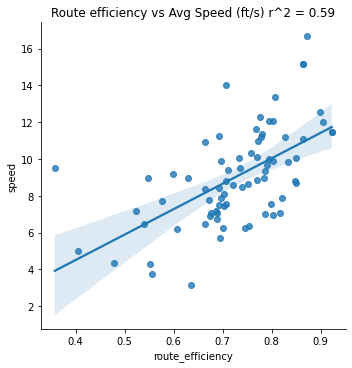

In [113]:
sns.lmplot(data=career_data,x='route_efficiency',y='speed').set(title='Route efficiency vs Avg Speed (ft/s) r^2 = 0.59')

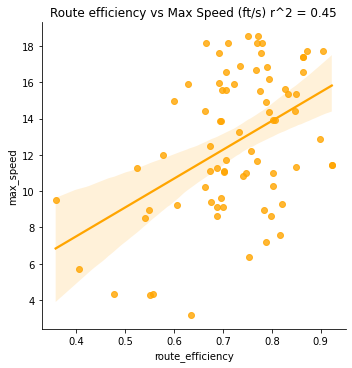

In [117]:
sns.lmplot(data=career_data,x='route_efficiency',y='max_speed', line_kws={'color': 'orange'},scatter_kws={'color':'orange'}).set(title='Route efficiency vs Max Speed (ft/s) r^2 = 0.45')

# avg_range vs speed, max_speed

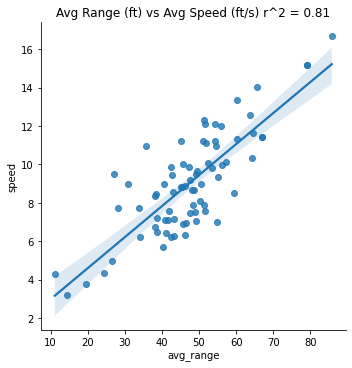

In [118]:
sns.lmplot(data=career_data,x='avg_range',y='speed').set(title='Avg Range (ft) vs Avg Speed (ft/s) r^2 = 0.81')

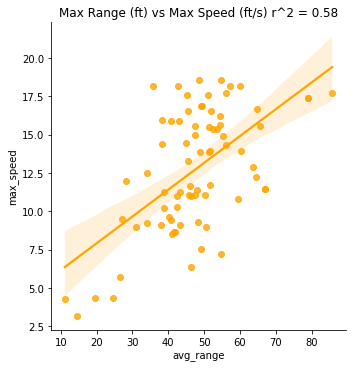

In [127]:
sns.lmplot(data=career_data,x='avg_range',y='max_speed', line_kws={'color': 'orange'},scatter_kws={'color':'orange'}).set(title='Max Range (ft) vs Max Speed (ft/s) r^2 = 0.58')

# first_step_rate vs first_step_speed, max_first_speed

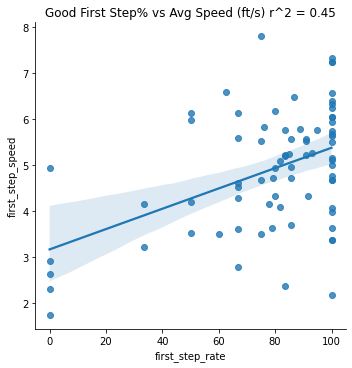

In [126]:
sns.lmplot(data=career_data,x='first_step_rate',y='first_step_speed').set(title='Good First Step% vs Avg Speed (ft/s) r^2 = 0.45')

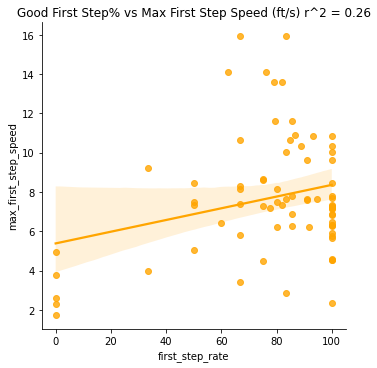

In [125]:
sns.lmplot(data=career_data,x='first_step_rate',y='max_first_step_speed', line_kws={'color': 'orange'},scatter_kws={'color':'orange'}).set(title='Good First Step% vs Max First Step Speed (ft/s) r^2 = 0.26')

# easy_catch_rate vs speed, max_speed

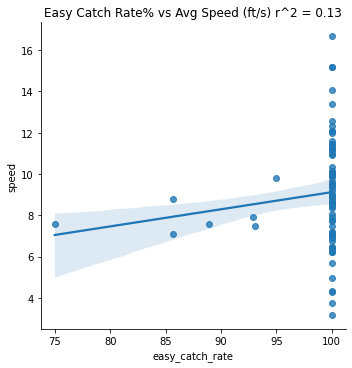

In [16]:
sns.lmplot(data=career_data,x='easy_catch_rate',y='speed').set(title='Easy Catch Rate% vs Avg Speed (ft/s) r^2 = 0.13')

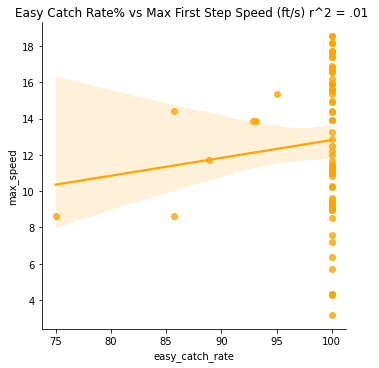

In [21]:
sns.lmplot(data=career_data,x='easy_catch_rate',y='max_speed',line_kws={'color':'orange'},scatter_kws={'color':'orange'}).set(title='Easy Catch Rate% vs Max First Step Speed (ft/s) r^2 = .01 ')

# Correlation Heatmaps

In [8]:
corr = career_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,center_field,avg_range,range,route_efficiency,speed,max_speed,first_step_speed,max_first_step_speed,first_step_rate,easy_catch_rate
center_field,1.000000,-0.170311,-0.124639,-0.171390,-0.064928,-0.084713,0.074677,-0.023177,-0.027695,0.100032
avg_range,-0.170311,1.000000,0.632859,0.751956,0.811885,0.584908,-0.101155,0.041402,0.274150,0.035388
range,-0.124639,0.632859,1.000000,0.433197,0.469557,0.742876,-0.025947,0.364166,0.372274,-0.013852
route_efficiency,-0.171390,0.751956,0.433197,1.000000,0.589517,0.450989,0.070530,0.112056,0.191133,-0.084312
speed,-0.064928,0.811885,0.469557,0.589517,1.000000,0.753798,-0.056817,-0.076780,0.321752,0.125450
max_speed,-0.084713,0.584908,0.742876,0.450989,0.753798,1.000000,0.104964,0.227830,0.471109,0.099014
first_step_speed,0.074677,-0.101155,-0.025947,0.070530,-0.056817,0.104964,1.000000,0.530835,0.454958,0.120567
max_first_step_speed,-0.023177,0.041402,0.364166,0.112056,-0.076780,0.227830,0.530835,1.000000,0.263783,0.041587
first_step_rate,-0.027695,0.274150,0.372274,0.191133,0.321752,0.471109,0.454958,0.263783,1.000000,-0.051460
easy_catch_rate,0.100032,0.035388,-0.013852,-0.084312,0.125450,0.099014,0.120567,0.041587,-0.051460,1.000000


In [10]:
corr = playli.corr()
corr.style.background_gradient(cmap='coolwarm')

,center_field,play_id,play_per_game,line_distance,full_distance,route_efficiency,time_delta,avg_speed,first_step_speed,first_step_check,hang_time,easy_catch
center_field,1.000000,-0.001107,0.000271,-0.022061,-0.019319,-0.029040,-0.007014,-0.011746,-0.021103,0.005158,-0.001703,0.013968
play_id,-0.001107,1.000000,0.999800,-0.024191,-0.076418,0.049725,-0.031956,-0.035560,0.016289,-0.009067,0.009425,-0.041766
play_per_game,0.000271,0.999800,1.000000,-0.025324,-0.077608,0.048921,-0.029683,-0.038305,0.016624,-0.008257,0.006835,-0.042305
line_distance,-0.022061,-0.024191,-0.025324,1.000000,0.873483,0.633216,0.015741,0.751052,0.185942,0.174818,0.160482,-0.104670
full_distance,-0.019319,-0.076418,-0.077608,0.873483,1.000000,0.229016,0.288689,0.677386,0.141761,0.061396,0.340551,-0.085413
route_efficiency,-0.029040,0.049725,0.048921,0.633216,0.229016,1.000000,-0.407881,0.462106,0.190257,0.313964,-0.244153,-0.060075
time_delta,-0.007014,-0.031956,-0.029683,0.015741,0.288689,-0.407881,1.000000,-0.457588,0.009572,-0.109203,0.471511,0.031173
avg_speed,-0.011746,-0.035560,-0.038305,0.751052,0.677386,0.462106,-0.457588,1.000000,0.121671,0.127080,-0.032620,-0.085002
first_step_speed,-0.021103,0.016289,0.016624,0.185942,0.141761,0.190257,0.009572,0.121671,1.000000,0.334684,-0.070865,0.001422
first_step_check,0.005158,-0.009067,-0.008257,0.174818,0.061396,0.313964,-0.109203,0.127080,0.334684,1.000000,-0.034798,0.108933


# Animate play

In [80]:
play = full_pos.query(f'new_id == "1902_28_TeamMC_TeamA11"').sort_values(by='timestamp',ascending=True)
play["player_position"].fillna(0, inplace = True)
play = play.query('player_position < 13.5')
play["player_position"] = play["player_position"].map({0 : 'ball',1: 'pitcher',2:'catcher',3:'first baseman', 4:'second baseman',5:'third baseman',6:'shortstop',7:'left field',8:'center field',9:'right field',10:'batter',11:'runner1',12:'runner2',13:'runner3'})


fig = px.scatter(play,x='field_x', y='field_y',color='player_position',animation_group='player_position',animation_frame='timestamp',range_x=[-250, 250])

fig.update_xaxes(visible=False) 
fig.update_yaxes(visible=False)
fig.show()